<a href="https://colab.research.google.com/github/rrl7012005/Deep-Learning-PyTorch/blob/main/NN_Classification_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets load the data. We will use the make_circles() method from sklearn to generate 2 circles with different colored dots.

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42) #Add noise

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Lets put this into a pandas dataframe.

In [ ]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


y is either 0 or 1 so its binary classification.

In [ ]:
circles.label.value_counts()

,count
label,
1,500
0,500


Plot them

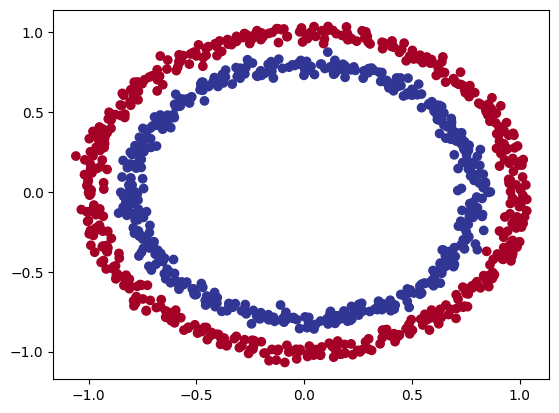

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu) #Applies red yellow blue colormap

Check the shapes

In [ ]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

X.shape, y.shape

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


((1000, 2), (1000,))

Now convert from numpy to tensors and split the data

In [ ]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#Building and Training a Model

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Create a 2 layer linear model, one hidden layer. The hidden layer has 5 neurons. There is no activation function by default.

In [ ]:
class CircleModel0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) #dimensionality expansion
    self.layer_2 = nn.Linear(in_features=5, out_features=1) #dimensionality reduction

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModel0().to(device)
model_0

CircleModel0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

We did that with functional API (model classing), we should do that with Sequential API, so we do not need to define the forward pass explicitly. it does it automatically, however it always runs in sequential order which can make it difficult for more difficult and complex networks (like resnets).

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Untrained predictions

In [ ]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.2195],
        [0.2700],
        [0.1602],
        [0.2360],
        [0.2764],
        [0.3063],
        [0.3565],
        [0.3653],
        [0.1554],
        [0.2747]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


##Loss function, evaluation function, optimizer

PyTorch has 2 binary cross entropy representations.

torch.nn.BCELoss()
torch.nn.BCEwithLogitsLoss()

The latter has a built in sigmoid layer.

For the optimizer use SGD.


Lets create an evaluation metric


Torch.eq calculates where 2 tensors are equal

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

##Training

The raw un modified outputs of our model are typically referred to as logits, we use a sigmoid to convert them into prediction probabilities.

In [ ]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2195],
        [0.2700],
        [0.1602],
        [0.2360],
        [0.2764]], grad_fn=<SliceBackward0>)

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5546],
        [0.5671],
        [0.5400],
        [0.5587],
        [0.5687]], grad_fn=<SigmoidBackward0>)

To turn probabilties into predictions, round the outputs of the sigmoid, and do some squeezing so outputs are in same form as predictions.

In [ ]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

Now the actual training loop

In [ ]:
torch.manual_seed(42)

epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    model_0.train() #Train mode


    y_logits = model_0(X_train).squeeze() # squeeze
    y_pred = torch.round(torch.sigmoid(y_logits)) # get preds

    #Using BCE with Logits loss works with raw logits
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70102, Accuracy: 50.00% | Test loss: 0.70239, Test acc: 50.00%
Epoch: 10 | Loss: 0.69606, Accuracy: 50.00% | Test loss: 0.69743, Test acc: 50.00%
Epoch: 20 | Loss: 0.69426, Accuracy: 51.25% | Test loss: 0.69556, Test acc: 53.00%
Epoch: 30 | Loss: 0.69359, Accuracy: 54.75% | Test loss: 0.69482, Test acc: 50.50%
Epoch: 40 | Loss: 0.69333, Accuracy: 52.50% | Test loss: 0.69452, Test acc: 48.50%
Epoch: 50 | Loss: 0.69322, Accuracy: 51.88% | Test loss: 0.69438, Test acc: 50.00%
Epoch: 60 | Loss: 0.69316, Accuracy: 51.25% | Test loss: 0.69433, Test acc: 49.00%
Epoch: 70 | Loss: 0.69312, Accuracy: 51.25% | Test loss: 0.69430, Test acc: 48.00%
Epoch: 80 | Loss: 0.69310, Accuracy: 51.12% | Test loss: 0.69430, Test acc: 48.50%
Epoch: 90 | Loss: 0.69308, Accuracy: 50.75% | Test loss: 0.69430, Test acc: 48.50%


Our model is not working so lets visualize. Lets plot the decision boundary.

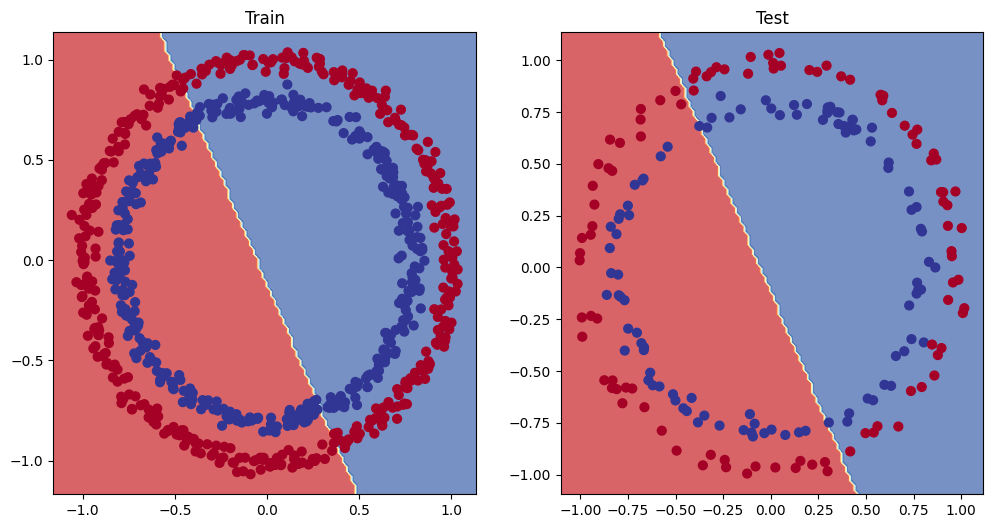

In [ ]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval() #change model to evaluation mode
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    #Test for multi class or binary
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    #Reshape and plot

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

As can see we are trying to create a linear decision boundary, we have not added non-linearities, clearly accuracy will be 50%. Clearly no matter how many layers we have it will be useless unless we add non-linearities.

Lets use RELU

In [ ]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        return x

model_3 = CircleModelV2().to(device)
print(model_3)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757,

Better but still poor, not enough non-linearity, lets look at predictions

In [ ]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

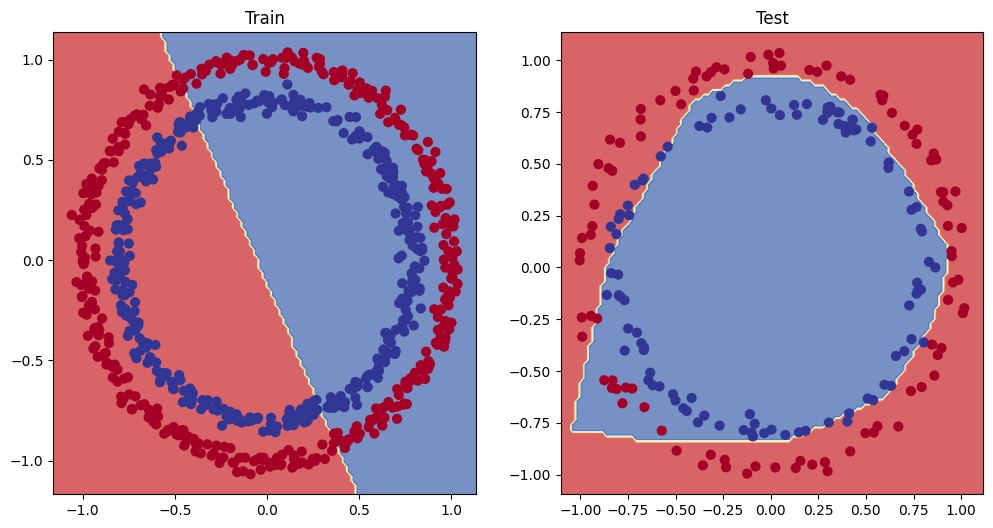

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

Decision boundary is looking really good, perhaps if we use some more layers it will be better.

In [ ]:
from sklearn.preprocessing import StandardScaler

class CircleModelV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=128)
        self.layer_2_5 = nn.Linear(in_features=128, out_features=256)
        self.layer_2_6 = nn.Linear(in_features=256, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=64)
        self.layer_4 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)  # Add dropout to prevent overfitting

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2_5(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2_6(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.layer_4(x)
        return x


model_4 = CircleModelV4().to(device)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train.to(device))
    acc = accuracy_fn(y_true=y_train.to(device), y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.no_grad():
        test_logits = model_4(X_test.to(device)).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test.to(device))
        test_acc = accuracy_fn(y_true=y_test.to(device), y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69324, Accuracy: 50.62% | Test Loss: 0.69280, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.12726, Accuracy: 95.50% | Test Loss: 0.05175, Test Accuracy: 99.50%
Epoch: 200 | Loss: 0.05870, Accuracy: 97.62% | Test Loss: 0.04944, Test Accuracy: 98.50%
Epoch: 300 | Loss: 0.02890, Accuracy: 98.88% | Test Loss: 0.05222, Test Accuracy: 97.50%
Epoch: 400 | Loss: 0.02817, Accuracy: 98.62% | Test Loss: 0.13582, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.02133, Accuracy: 99.38% | Test Loss: 0.09513, Test Accuracy: 96.50%
Epoch: 600 | Loss: 0.00865, Accuracy: 99.62% | Test Loss: 0.11724, Test Accuracy: 96.00%
Epoch: 700 | Loss: 0.03010, Accuracy: 98.62% | Test Loss: 0.08264, Test Accuracy: 96.00%
Epoch: 800 | Loss: 0.01109, Accuracy: 99.88% | Test Loss: 0.04657, Test Accuracy: 97.50%
Epoch: 900 | Loss: 0.00604, Accuracy: 99.88% | Test Loss: 0.07328, Test Accuracy: 97.00%


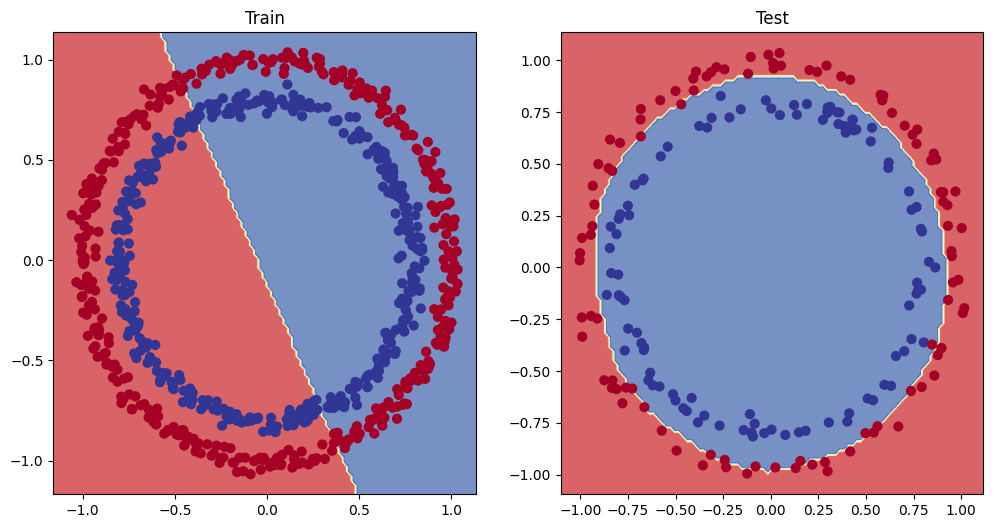

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

Swag

#Multi-class classification

For our dataset use sci kits make_blobs method which will create many classes.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


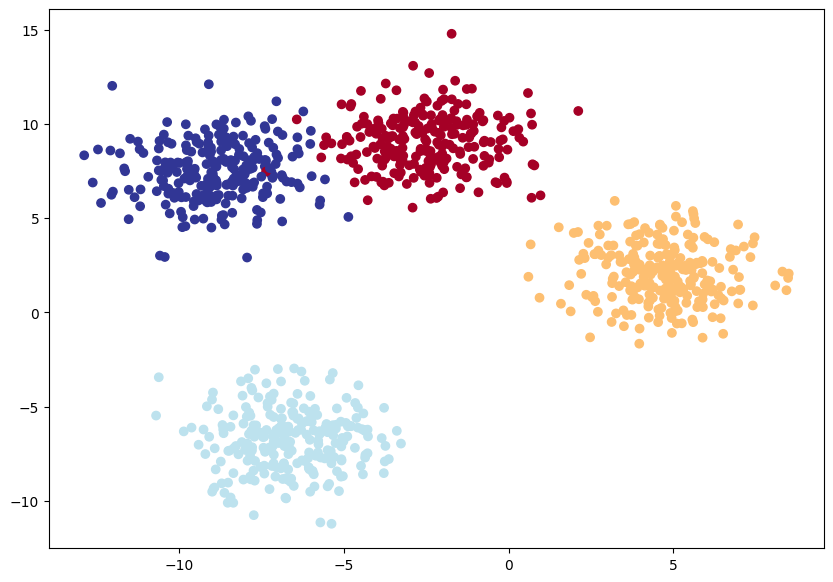

In [ ]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2 #For our data
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # cluster sd
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Our error function will be cross entropy, but first we need to softmax it.

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)  #Softmax along the rows
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], grad_fn=<SliceBackward0>)


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.7099, 0.0285, 0.2185, 0.0432], grad_fn=<SelectBackward0>)
tensor(0)


In [ ]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


##Predictions

In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


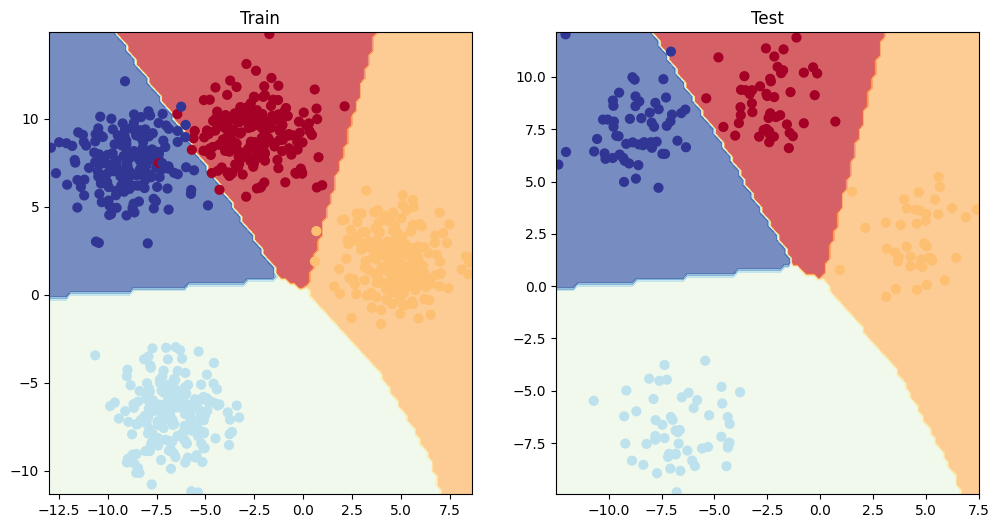

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

Accuracy

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 6.8 MB/s eta 0:00:00


tensor(0.9950)